# Introduction

This notebook presents a practical and comparative study of algorithms for solving the **Traveling Salesman Problem (TSP)** on real-world networks. The goal was to create a flexible and realistic pipeline that takes a set of addresses and a specified network type (e.g., drive, walk, bike) as input, and produces efficient route approximations using advanced optimization techniques.

The pipeline is built as follows:

1. **Data Acquisition from OpenStreetMap (OSM):**  
   Using the `osmnx` library, the notebook extracts a subgraph of a real-world network that contains all input addresses.

2. **Node Mapping:**  
   Each address is geocoded and mapped to its nearest node in the network.

3. **Distance Matrix Construction:**  
   A distance matrix is built based on real network distances (not Euclidean), using the OSM graph.

4. **TSP Solvers Applied:**  
   Three heuristic/metaheuristic algorithms are implemented and tested:
   - **2-Opt with Smoothing:** a custom variant that dynamically adjusts the distance matrix during optimization.
   - **Simulated Annealing**
   - **Ant Colony Optimization (ACO)**

5. **Experimental Comparison:**  
   Each algorithm is executed **30 times** to evaluate both solution quality (total route length) and computational performance (execution time). Descriptive statistics are provided for both metrics.

6. **Visualization of Results:**  
   The best route from the 30 runs of each algorithm is graphically plotted on the network.

This work demonstrates the **practical usability** of TSP solvers on real-world data, providing insights into the **efficiency and reliability** of different approaches under realistic conditions. The code and methods can be adapted to solve routing problems in logistics, delivery, urban planning, and similar fields.

# Libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import time
import networkx as nx
import osmnx as ox

# Addresses and Network Type

In [37]:
# Define the type of network to be used from OpenStreetMap.
# Possible options include 'walk', 'drive', 'bike', etc.
network_type = "walk"

# List of addresses in Paris, France, to be used as TSP nodes.
# These addresses will be geocoded and matched to the nearest nodes in the OSM network.
# The resulting set of nodes will form the basis for route optimization.
addresses = [
    "Avenue des Champs-Élysées 50, 75008 Paris, France",
    "Boulevard Haussmann 120, 75008 Paris, France",
    "Place de la Bastille, 75011 Paris, France",
    "Place de la République, 75003 Paris, France",
    "Place de la Concorde, 75008 Paris, France",
    "Avenue de la Grande Armée 10, 75017 Paris, France",
    "Boulevard Saint-Michel 45, 75005 Paris, France",
    "Rue de Vaugirard 200, 75015 Paris, France",
    "Place Charles de Gaulle, 75008 Paris, France",
    "Boulevard Voltaire 150, 75011 Paris, France",
    "Rue de Rivoli 140, 75001 Paris, France",
    "Rue de Rennes 60, 75006 Paris, France",
    "Boulevard Raspail 80, 75006 Paris, France",
    "Place d'Italie, 75013 Paris, France",
    "Rue Lecourbe 220, 75015 Paris, France",
    "Rue de la Convention 150, 75015 Paris, France",
    "Avenue Mozart 80, 75016 Paris, France",
    "Rue de Passy 60, 75016 Paris, France",
    "Avenue Victor Hugo 100, 75016 Paris, France",
    "Avenue Foch 1, 75016 Paris, France",
    "Boulevard Malesherbes 110, 75017 Paris, France",
    "Rue de Courcelles 90, 75017 Paris, France",
    "Place de Clichy, 75017 Paris, France",
    "Rue Saint-Lazare 120, 75008 Paris, France",
    "Avenue de Clichy 180, 75017 Paris, France",
    "Rue Ordener 100, 75018 Paris, France",
    "Rue Championnet 130, 75018 Paris, France",
    "Boulevard Barbès 80, 75018 Paris, France",
    "Avenue Jean Jaurès 150, 75019 Paris, France",
    "Boulevard Sérurier 50, 75019 Paris, France",
    "Rue Pelleport 100, 75020 Paris, France",
    "Rue des Pyrénées 300, 75020 Paris, France",
    "Rue de Bagnolet 200, 75020 Paris, France",
    "Boulevard Davout 180, 75020 Paris, France",
    "Rue Tolbiac 180, 75013 Paris, France",
    "Rue de Charenton 300, 75012 Paris, France",
    "Boulevard Diderot 100, 75012 Paris, France",
    "Rue de Reuilly 110, 75012 Paris, France",
    "Rue du Faubourg Saint-Antoine 150, 75011 Paris, France",
    "Avenue Ledru-Rollin 100, 75011 Paris, France",
    "Rue Oberkampf 100, 75011 Paris, France",
    "Rue de Turbigo 60, 75003 Paris, France",
    "Rue Saint-Denis 250, 75002 Paris, France",
    "Rue Réaumur 100, 75002 Paris, France",
    "Rue du Faubourg Montmartre 50, 75009 Paris, France",
    "Rue de Châteaudun 80, 75009 Paris, France",
    "Rue d'Amsterdam 90, 75008 Paris, France",
    "Boulevard de Magenta 120, 75010 Paris, France",
    "Rue de Maubeuge 100, 75010 Paris, France",
]

# Helper Functions

In [38]:
def geocode_addresses(addresses):
    """
    Geocode a list of addresses into latitude and longitude coordinates.

    Parameters:
        addresses (list of str): A list of address strings to be geocoded.

    Returns:
        list of tuple or None: A list of (latitude, longitude) tuples corresponding to each address.
                               If geocoding fails for an address, None is added in its place.
    """
    coords = []  # List to store the resulting coordinates

    for address in addresses:
        try:
            # Attempt to geocode the address using OSMnx's geocoder
            latlon = ox.geocoder.geocode(address)
            coords.append(latlon)
        except Exception as e:
            # If geocoding fails, print an error message and append None
            print(f"Error geocoding '{address}': {e}")
            coords.append(None)

    return coords  # Return list of coordinates (or None where failed)

In [39]:
def get_min_max_coordinates(coords):
    """
    Calculate the bounding box (with padding) that contains all given coordinates.

    Parameters:
        coords (list of tuple): A list of (latitude, longitude) tuples.

    Returns:
        tuple: A bounding box in the format (min_lon, min_lat, max_lon, max_lat),
               with a small padding (0.015 degrees) added to each boundary.
    """
    # Extract latitudes and longitudes from the coordinate tuples
    latitudes = [lat for lat, lon in coords]
    longitudes = [lon for lat, lon in coords]

    # Calculate the min and max values for latitudes and longitudes
    min_lat = min(latitudes)
    max_lat = max(latitudes)
    min_lon = min(longitudes)
    max_lon = max(longitudes)

    # Return the bounding box with a small padding added to each side
    return (min_lon - 0.015, min_lat - 0.015, max_lon + 0.015, max_lat + 0.015)

In [40]:
def nearest_neighbor_tsp(starting_node, subset_nodes, distance_matrix):
    """
    Solve a TSP instance using the Nearest Neighbor heuristic.

    Parameters:
        starting_node (int): The node to start and end the tour.
        subset_nodes (iterable of int): The set of node indices to visit.
        distance_matrix (2D list or array): A matrix containing distances between nodes.

    Returns:
        list of int: A list representing the TSP tour, starting and ending at the starting_node.
    """
    # Initialize the set of nodes to visit (excluding the starting node)
    unvisited = set(subset_nodes)
    unvisited.discard(starting_node)

    current_node = starting_node
    route = [starting_node]  # Start route with the starting node

    # Iteratively visit the nearest unvisited node
    while unvisited:
        next_node = min(unvisited, key=lambda node: distance_matrix[current_node][node])
        route.append(next_node)
        unvisited.remove(next_node)
        current_node = next_node

    route.append(starting_node)  # Return to the starting node to complete the tour
    return route

In [41]:
def dist_matrix(G, subset_nodes):
    """
    Compute the pairwise shortest path distances between a subset of nodes in a graph.

    Parameters:
        G (networkx.Graph): A NetworkX graph, typically created from OSM data.
        subset_nodes (list of int): A list of node IDs for which to compute pairwise distances.

    Returns:
        dict of dict: A nested dictionary where distance_matrix[u][v] gives the shortest path
                      length between nodes u and v using Dijkstra's algorithm.
    """
    distance_matrix = {}

    # Loop over each node u in the subset
    for u in subset_nodes:
        distance_matrix[u] = {}

        # Loop over each node v in the subset (including u itself)
        for v in subset_nodes:
            # Compute the shortest path length from u to v using edge weights (length)
            distance_matrix[u][v] = nx.dijkstra_path_length(G, u, v, weight='length')

    return distance_matrix

In [42]:
def normalized_dist_matrix(distance_matrix):
    """
    Normalize the values in a nested distance matrix to the range [0, 1].
    
    This function takes a dictionary representing distances between nodes (distance_matrix),
    finds the minimum and maximum distances, and applies min-max normalization:
        normalized_value = (value - min) / (max - min)
    If all distances are equal, it returns 0 for all entries to avoid division by zero.

    Args:
        distance_matrix (dict): Nested dictionary where distance_matrix[u][v] gives the distance from u to v.

    Returns:
        dict: A new nested dictionary with distances normalized between 0 and 1.
    """
    
    # Initialize dictionary to hold normalized distances
    normalized_distance_matrix = {}

    # Initialize min and max distances to extremes for finding global min/max
    min_distance = float('inf')
    max_distance = float('-inf')

    # Iterate through all distances to find global minimum and maximum
    for u in distance_matrix:
        for v in distance_matrix[u]:
            d = distance_matrix[u][v]
            min_distance = min(min_distance, d)
            max_distance = max(max_distance, d)

    # Normalize distances using min-max scaling
    for u in distance_matrix:
        normalized_distance_matrix[u] = {}  # Initialize sub-dictionary for node u
        for v in distance_matrix[u]:
            d = distance_matrix[u][v]
            # Apply normalization formula if max and min differ, else set 0 to avoid division by zero
            if max_distance != min_distance:
                normalized_distance_matrix[u][v] = (d - min_distance) / (max_distance - min_distance)
            else:
                normalized_distance_matrix[u][v] = 0

    return normalized_distance_matrix

In [43]:
def total_distance_matrix(tour, dist_matrix):
    """
    Calculate the total distance of a given tour based on the provided distance matrix.

    Args:
        tour (list): A list of nodes representing the order in which they are visited.
        dist_matrix (dict): Nested dictionary where dist_matrix[u][v] gives the distance from node u to node v.

    Returns:
        float: The sum of distances along the entire tour, including the return to the starting node.
    """
    # Sum the distances between consecutive nodes in the tour,
    # including the edge from the last node back to the first (to complete the cycle)
    return sum(dist_matrix[tour[i]][tour[(i + 1) % len(tour)]] for i in range(len(tour)))

In [44]:
def two_opt_swap(tour, i, k):
    """
    Perform a 2-opt swap on the tour between indices i and k.
    
    This operation takes a segment of the tour between positions i+1 and k,
    reverses it, and reconnects it to the rest of the tour, producing a new tour.

    Args:
        tour (list): The current tour (list of nodes).
        i (int): The start index of the segment to reverse.
        k (int): The end index of the segment to reverse.

    Returns:
        list: A new tour with the segment between i+1 and k reversed.
    """
    # Return a new tour:
    # - nodes from start to i (inclusive),
    # - reversed segment from i+1 to k (inclusive),
    # - nodes from k+1 to the end
    return tour[:i+1] + tour[i+1:k+1][::-1] + tour[k+1:]

In [45]:
import random

def two_opt_with_matrix(dist_matrix, initial_tour=None):
    """
    Perform the 2-opt optimization on a tour to improve its total distance.

    Args:
        dist_matrix (dict): Nested dictionary representing distances between nodes.
        initial_tour (list, optional): Starting tour (list of nodes). 
                                       If None, a random tour is generated.

    Returns:
        list: An optimized tour with improved (shorter) total distance.
              The tour is a cycle: the first node is appended at the end.
    """

    # Extract all nodes from the distance matrix keys
    nodes = list(dist_matrix.keys())

    # If no initial tour provided, create a random permutation of nodes
    if initial_tour is None:
        tour = nodes[:]
        random.shuffle(tour)
    else:
        # Copy the initial tour to avoid modifying the original
        tour = initial_tour[:]

    # Ensure the tour is cyclic by appending the start node to the end if needed
    if tour[0] != tour[-1]:
        tour.append(tour[0])

    # Calculate the total distance of the current tour
    best_distance = total_distance_matrix(tour, dist_matrix)
    improved = True

    # Repeat the improvement loop until no better tour is found
    while improved:
        improved = False
        # Iterate over possible edges to swap
        for i in range(1, len(tour) - 2):
            for k in range(i + 1, len(tour) - 1):
                # Generate a new tour by performing a 2-opt swap between i and k
                new_tour = two_opt_swap(tour, i, k)
                # Calculate the total distance of the new tour
                new_distance = total_distance_matrix(new_tour, dist_matrix)

                # If the new tour is better (shorter), update tour and best distance
                if new_distance < best_distance:
                    tour = new_tour
                    best_distance = new_distance
                    improved = True
                    break  # Exit inner loop to restart checking with new tour
            if improved:
                break  # Exit outer loop early to restart from beginning

    return tour

# Graph Generation

In [46]:
def graph_generation(addresses, network_type):
    """
    Generate and plot a street network graph based on input addresses and network type.

    This function:
    - Geocodes addresses to get their coordinates.
    - Computes a bounding box covering all coordinates.
    - Downloads the OpenStreetMap graph within the bounding box for the specified network type.
    - Projects the graph to the appropriate coordinate reference system.
    - Finds the nearest graph nodes to the input coordinates.
    - Visualizes the graph highlighting the subset nodes corresponding to the addresses.

    Args:
        addresses (list): List of address strings to geocode.
        network_type (str): Type of street network to download ('walk', 'drive', etc.).

    Returns:
        G (networkx.MultiDiGraph): The raw downloaded graph.
        G_proj (networkx.MultiDiGraph): The projected graph.
        subset_nodes (list): List of node IDs nearest to the input addresses.
    """

    # Convert addresses to geographic coordinates (latitude, longitude)
    coords = geocode_addresses(addresses)

    # Calculate bounding box (min_lat, max_lat, min_lon, max_lon) covering all coords
    bbox = get_min_max_coordinates(coords)

    # Download street network graph from OpenStreetMap inside the bounding box
    G = ox.graph.graph_from_bbox(
        bbox,
        network_type=network_type
    )

    # Project the graph to the appropriate projected CRS (meters, for distance calculations)
    G_proj = ox.project_graph(G)

    # Separate latitudes and longitudes for nearest node search
    lats, lons = zip(*coords)

    # Find the nearest graph nodes to each coordinate (ox.distance.nearest_nodes expects X=longitudes, Y=latitudes)
    subset_nodes = [int(node) for node in ox.distance.nearest_nodes(G, X=lons, Y=lats)]

    # Assign colors to nodes: red if in subset_nodes, otherwise light gray
    node_colors = [
        "red" if node in subset_nodes else "lightgray"
        for node in G_proj.nodes
    ]

    # Set node sizes: larger size for subset nodes, zero size for others (invisible)
    node_sizes = [15 if node in subset_nodes else 0 for node in G_proj.nodes]

    # Plot the projected graph with customized node colors and sizes
    fig, ax = ox.plot_graph(
        G_proj,
        bgcolor="white",
        node_color=node_colors,
        node_size=node_sizes,
        edge_color="gray",
        edge_linewidth=0.2,
        show=True,
        close=True
    )

    # Return the raw graph, projected graph, and subset nodes
    return G, G_proj, subset_nodes

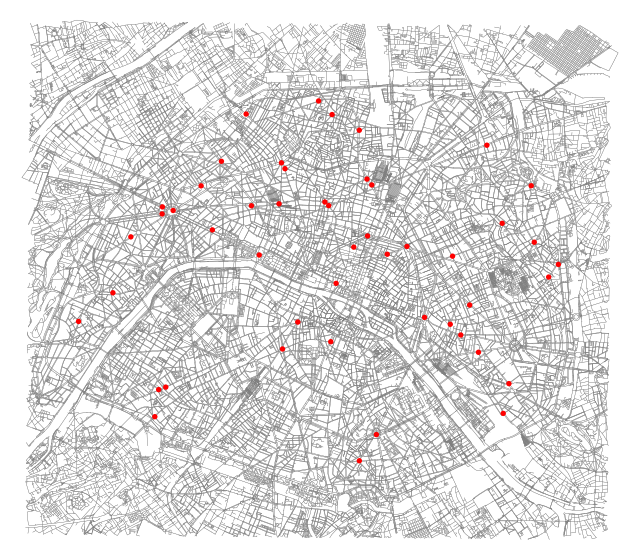

In [47]:
G, G_proj, subset_nodes = graph_generation(addresses, network_type)

# Distance Matrix

In [48]:
distance_matrix = dist_matrix(G, subset_nodes)

normalized_distance_matrix = normalized_dist_matrix(distance_matrix)

optimized_tour = nearest_neighbor_tsp(subset_nodes[0], subset_nodes, distance_matrix)

# Heuristics / Metaheuristics

In [49]:
def tsp_smoothing(subset_nodes, normalized_distance_matrix, optimized_tour, alpha_number=10):
    """
    Improve a TSP tour by applying smoothing transformations on the distance matrix using
    an alpha parameter, followed by 2-opt optimization on each transformed matrix.

    The smoothing adjusts distances non-linearly around the average distance to potentially
    escape local minima and find better tours.

    Args:
        subset_nodes (list): List of nodes in the TSP problem.
        normalized_distance_matrix (dict): Nested dict of normalized distances between nodes.
        optimized_tour (list): Initial tour (list of nodes) to be improved.
        alpha_number (int): Number of alpha smoothing steps (default 10).

    Returns:
        tuple: (optimized_tour, total_distance) where optimized_tour is the improved tour,
               and total_distance is its total distance evaluated on the normalized matrix.
    """

    # Calculate the average distance d_avg over all distinct node pairs
    total = sum(
        normalized_distance_matrix[u][v]
        for u in subset_nodes for v in subset_nodes if u != v
    )
    n = len(subset_nodes)
    d_avg = total / (n * (n - 1))

    # Generate alpha values descending from alpha_number down to 1
    alpha = list(range(alpha_number, 0, -1))

    # Iterate over alpha values to create and optimize over smoothed distance matrices
    for a in alpha:
        # Initialize a new alpha-smoothed distance matrix
        alpha_distance_matrix = {u: {} for u in subset_nodes}

        for i in subset_nodes:
            for j in subset_nodes:
                if i == j:
                    # Distance to self is zero
                    alpha_distance_matrix[i][j] = 0.0
                else:
                    d = normalized_distance_matrix[i][j]
                    # Apply smoothing:
                    # - If distance >= average, increase/decrease distance with power a relative to d_avg
                    # - If distance < average, do the inverse
                    if d >= d_avg:
                        alpha_distance_matrix[i][j] = d_avg + (d - d_avg)**a
                    else:
                        alpha_distance_matrix[i][j] = d_avg - (d_avg - d)**a

        # Improve the current tour using 2-opt on the smoothed distance matrix
        optimized_tour = two_opt_with_matrix(alpha_distance_matrix, optimized_tour)

        # Ensure the tour is cyclic by appending start node if missing at the end
        if optimized_tour[0] != optimized_tour[-1]:
            optimized_tour.append(optimized_tour[0])

        # Calculate the total distance of the improved tour on the original normalized distances
        total_distance = total_distance_matrix(optimized_tour, normalized_distance_matrix)

    return optimized_tour, total_distance

In [50]:
def simulated_annealing_tsp(dist_matrix, initial_tour=None, initial_temp=100000, cooling_rate=0.999, stopping_temp=1e-8, max_iterations=100000):
    """
    Solve the TSP using Simulated Annealing optimization.

    Args:
        dist_matrix (dict): Nested dictionary with distances between nodes.
        initial_tour (list, optional): Starting tour. If None, a random tour is generated.
        initial_temp (float): Starting temperature for annealing.
        cooling_rate (float): Rate at which temperature decreases each iteration.
        stopping_temp (float): Temperature at which the algorithm stops.
        max_iterations (int): Maximum number of iterations to run.

    Returns:
        tuple: (best_tour, best_cost) where best_tour is the shortest tour found,
               and best_cost is its total distance.
    """

    nodes = list(dist_matrix.keys())

    # Initialize current tour: random if none provided, else copy given tour
    if initial_tour is None:
        current_tour = nodes[:]
        random.shuffle(current_tour)
    else:
        current_tour = initial_tour[:]

    # Ensure tour is cyclic by appending start node to the end if necessary
    if current_tour[0] != current_tour[-1]:
        current_tour.append(current_tour[0])

    # Calculate cost of the current tour
    current_cost = total_distance_matrix(current_tour, dist_matrix)
    best_tour = current_tour[:]
    best_cost = current_cost

    temperature = initial_temp

    for iteration in range(max_iterations):
        # Stop if temperature falls below stopping threshold
        if temperature < stopping_temp:
            break

        # Randomly select two indices for the 2-opt swap (excluding start/end node)
        i, k = sorted(random.sample(range(1, len(current_tour) - 1), 2))

        # Generate new candidate tour with 2-opt swap
        new_tour = two_opt_swap(current_tour, i, k)
        new_cost = total_distance_matrix(new_tour, dist_matrix)

        delta = new_cost - current_cost

        # Decide whether to accept the new tour:
        # - Accept if new tour is better (delta < 0)
        # - Otherwise, accept with probability depending on temperature (Metropolis criterion)
        if delta < 0 or random.random() < math.exp(-delta / temperature):
            current_tour = new_tour
            current_cost = new_cost
            # Update best found solution if improved
            if current_cost < best_cost:
                best_tour = current_tour
                best_cost = current_cost

        # Cool down the temperature
        temperature *= cooling_rate

    return best_tour, best_cost

In [51]:
def ant_colony_optimization_tsp_classic(dist_matrix, n_ants=20, n_iterations=100, alpha=2.0, beta=5.0, rho=0.5, Q=100):
    """
    Classic Ant Colony Optimization (ACO) algorithm for solving the Traveling Salesman Problem (TSP).

    Args:
        dist_matrix (dict): Nested dictionary where dist_matrix[i][j] is the distance between nodes i and j.
        n_ants (int): Number of ants per iteration.
        n_iterations (int): Number of iterations to run the algorithm.
        alpha (float): Exponent for pheromone importance.
        beta (float): Exponent for heuristic importance (usually inverse distance).
        rho (float): Pheromone evaporation rate (0 < rho < 1).
        Q (float): Constant used for pheromone deposit calculation.

    Returns:
        tuple: (best_tour, best_length) where best_tour is the shortest tour found,
               and best_length is its total distance.
    """

    nodes = list(dist_matrix.keys())
    n = len(nodes)

    # Initialize pheromone levels uniformly to 1.0 for all edges
    pheromones = {i: {j: 1.0 for j in nodes} for i in nodes}

    # Calculate heuristic desirability (eta), usually inverse of distance,
    # use a large number (1e6) if distance is zero to avoid division errors
    heuristic = {
        i: {
            j: (1.0 / dist_matrix[i][j] if dist_matrix[i][j] > 0 else 1e6)
            for j in nodes
        }
        for i in nodes
    }

    def construct_ant_tour():
        # Start tour from a random node
        start = random.choice(nodes)
        unvisited = set(nodes)
        unvisited.remove(start)
        tour = [start]

        current = start
        # Visit all nodes according to probabilistic choice based on pheromone and heuristic info
        while unvisited:
            probabilities = []
            denominator = 0.0

            # Compute denominator for probabilities (sum of tau^alpha * eta^beta over unvisited nodes)
            for j in unvisited:
                tau = pheromones[current][j] ** alpha
                eta = heuristic[current][j] ** beta
                denominator += tau * eta

            # If denominator is zero (no pheromone or heuristic info), choose next node randomly
            if denominator == 0.0:
                next_node = random.choice(list(unvisited))
            else:
                # Calculate probability for each candidate next node
                for j in unvisited:
                    tau = pheromones[current][j] ** alpha
                    eta = heuristic[current][j] ** beta
                    probability = (tau * eta) / denominator
                    probabilities.append((j, probability))

                # Roulette wheel selection based on cumulative probabilities
                r = random.uniform(0, 1)
                cumulative = 0.0
                for j, p in probabilities:
                    cumulative += p
                    if r <= cumulative:
                        next_node = j
                        break

            # Move to the chosen next node and mark it visited
            tour.append(next_node)
            unvisited.remove(next_node)
            current = next_node

        # Close the tour by returning to the start node
        tour.append(start)
        return tour

    def evaporate_pheromones():
        # Evaporate pheromone on all edges to simulate fading over time
        for i in nodes:
            for j in nodes:
                pheromones[i][j] *= (1 - rho)
                # Avoid pheromone values dropping below a minimum threshold
                if pheromones[i][j] < 1e-8:
                    pheromones[i][j] = 1e-8

    def deposit_pheromones(tour, length):
        # Deposit pheromone inversely proportional to tour length on all edges in the tour
        for i in range(len(tour) - 1):
            u = tour[i]
            v = tour[i + 1]
            delta = Q / length
            pheromones[u][v] += delta

    best_tour = None
    best_length = float('inf')

    # Main optimization loop over iterations
    for iteration in range(n_iterations):
        all_tours = []
        # Each ant constructs a tour
        for _ in range(n_ants):
            tour = construct_ant_tour()
            length = total_distance_matrix(tour, dist_matrix)
            all_tours.append((tour, length))
            # Track the best tour found so far
            if length < best_length:
                best_tour = tour
                best_length = length

        # Pheromone evaporation step
        evaporate_pheromones()
        # Pheromone deposit step: all ants deposit pheromones proportional to tour quality
        for tour, length in all_tours:
            deposit_pheromones(tour, length)

    return best_tour, best_length

# Results

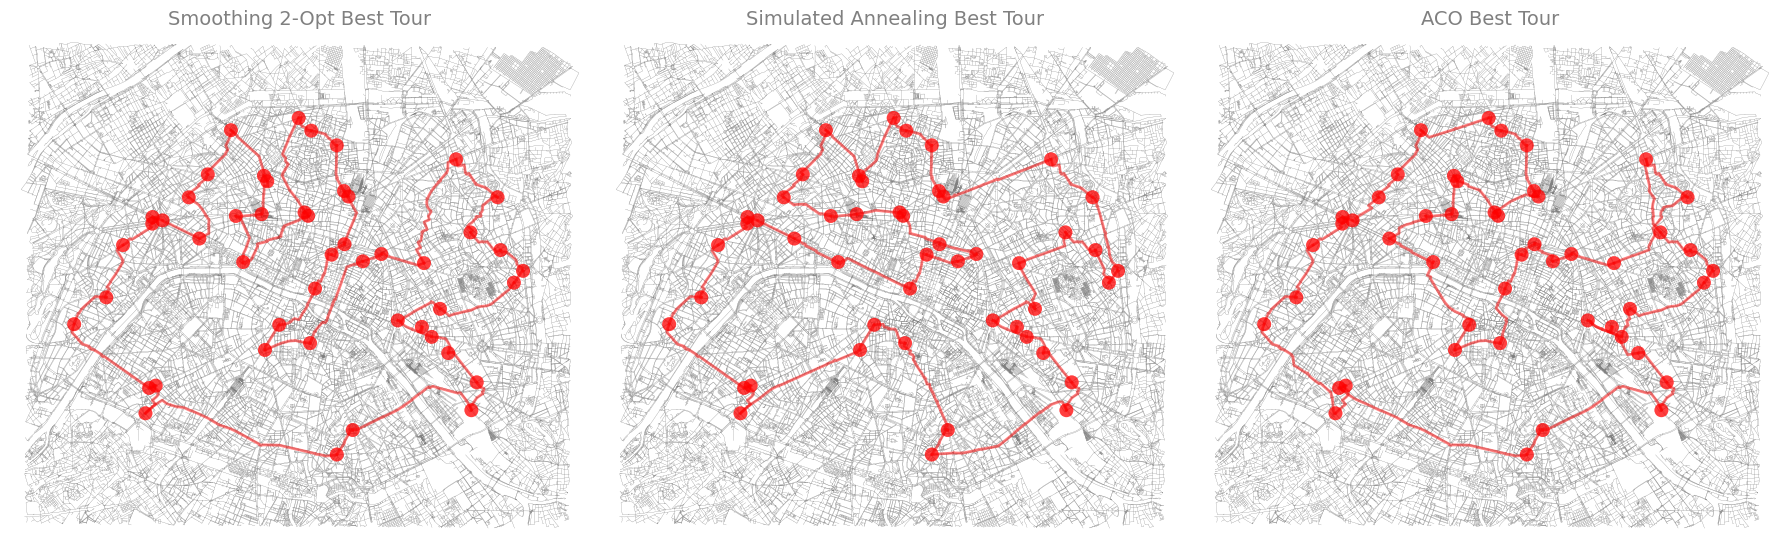

Time (s)                         Quality                  \
                        mean     std     min     max    mean     std     min   
Algorithm                                                                      
ACO                   2.6571  0.0175  2.6186  2.7057  5.0016  0.0846  4.8271   
Simulated Annealing   0.5515  0.0044  0.5446  0.5673  4.9083  0.1424  4.7302   
Smoothing 2-Opt       0.3471  0.0087  0.3335  0.3670  4.9643  0.0000  4.9643   

                             
                        max  
Algorithm                    
ACO                  5.1749  
Simulated Annealing  5.2796  
Smoothing 2-Opt      4.9643

In [52]:
n_runs = 30  # Number of times each algorithm will run for statistical robustness

results = {
    "Algorithm": [],
    "Time (s)": [],
    "Quality": []
}

# Store best tour and quality (distance) found per algorithm
best_solutions = {
    "Smoothing 2-Opt": (None, float("inf")),
    "Simulated Annealing": (None, float("inf")),
    "ACO": (None, float("inf"))
}

# Define each algorithm as a name-function pair (using lambdas to delay execution)
for algo_name, algo_func in [
    ("Smoothing 2-Opt", lambda: tsp_smoothing(subset_nodes, normalized_distance_matrix, optimized_tour)),
    ("Simulated Annealing", lambda: simulated_annealing_tsp(normalized_distance_matrix, initial_tour=optimized_tour)),
    ("ACO", lambda: ant_colony_optimization_tsp_classic(normalized_distance_matrix))
]:
    for _ in range(n_runs):
        start_time = time.time()
        tour, dist = algo_func()  # Run algorithm
        elapsed = time.time() - start_time

        # Save results for statistical analysis
        results["Algorithm"].append(algo_name)
        results["Time (s)"].append(elapsed)
        results["Quality"].append(dist)

        # Track the best solution found by the algorithm
        if dist < best_solutions[algo_name][1]:
            best_solutions[algo_name] = (tour, dist)

# Create a DataFrame from results for analysis
df = pd.DataFrame(results)

# Summarize timing and quality statistics: mean, std, min, max per algorithm
summary = df.groupby("Algorithm").agg({
    "Time (s)": ["mean", "std", "min", "max"],
    "Quality": ["mean", "std", "min", "max"]
}).round(4)

# Prepare plotting subplots, one per algorithm
n_algos = len(best_solutions)
fig, axes = plt.subplots(1, n_algos, figsize=(6 * n_algos, 6), facecolor='white')

# Ensure axes is iterable when only one algorithm
if n_algos == 1:
    axes = [axes]

# Plot best tour for each algorithm
for ax, (algo_name, (tour, _)) in zip(axes, best_solutions.items()):
    # Plot the projected graph as a base layer with very subtle edges
    fig_, ax_ = ox.plot_graph(
        G_proj,
        ax=ax,
        show=False,
        close=False,
        node_size=0,
        edge_color='gray',
        edge_linewidth=0.1,
        bgcolor='white'
    )

    route_edges = list(zip(tour[:-1], tour[1:]))
    for u, v in route_edges:
        try:
            # Find shortest path on the graph between consecutive nodes in the tour
            route = nx.shortest_path(G_proj, u, v, weight='length')
            # Overlay the route segment in red on the graph
            ox.plot_graph_route(
                G_proj,
                route,
                route_color='red',
                route_linewidth=2,
                ax=ax,
                show=False,
                close=False
            )
        except nx.NetworkXNoPath:
            print(f"[{algo_name}] No path between {u} and {v}, skipping.")

    ax.set_title(f"{algo_name} Best Tour", color='gray', fontsize=14)

plt.tight_layout()
plt.show()

# Display summary statistics of the runs
summary.head()